# Outline

#### 1. Exploratory data analysis (EDA)

1.1 Basic statistics

1.2 Column without meaning / constant value

1.3 Categorical variables: Distinct columns values

1.4 Continuous variables: Plotting distributions

#### 2. Preprocessing and Feature Engineering (functions)

2.1 Handle Missing Values 

2.2 Handle outliers

2.3 Drop features 

2.4 Text processing 

2.5 Encoding categorical variables 


#### 3. Answering the challenges
#### 4. Tests

Zhaoxue Li 2023 April 6th

# 0. Import libraries and read data

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder. \
    appName("pyspark-1"). \
    getOrCreate()

from pyspark.sql import DataFrame, Column
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.window import Window

from pyspark.ml.feature import (VectorAssembler,VectorIndexer,
                                OneHotEncoder,StringIndexer)


### Read data

In [2]:
# Upon first inspecting the dataframe using default load options, 
# I found that the data is not parsed correctly due to commas and quotes in fields.
# Adding quotes option solved it

df = spark.read.options(header=True, inferSchema=True)\
.option("quote", "\"")\
.option("escape", "\"")\
.csv("/dataset/nyc-jobs.csv")

In [3]:
print('There are {} rows in dataframe'.format(df.count()))
print('---------------------------------')
print('Below is the dataframe schema:')
df.printSchema()

There are 2946 rows in dataframe
---------------------------------
Below is the dataframe schema:
root
 |-- Job ID: integer (nullable = true)
 |-- Agency: string (nullable = true)
 |-- Posting Type: string (nullable = true)
 |-- # Of Positions: integer (nullable = true)
 |-- Business Title: string (nullable = true)
 |-- Civil Service Title: string (nullable = true)
 |-- Title Code No: string (nullable = true)
 |-- Level: string (nullable = true)
 |-- Job Category: string (nullable = true)
 |-- Full-Time/Part-Time indicator: string (nullable = true)
 |-- Salary Range From: double (nullable = true)
 |-- Salary Range To: double (nullable = true)
 |-- Salary Frequency: string (nullable = true)
 |-- Work Location: string (nullable = true)
 |-- Division/Work Unit: string (nullable = true)
 |-- Job Description: string (nullable = true)
 |-- Minimum Qual Requirements: string (nullable = true)
 |-- Preferred Skills: string (nullable = true)
 |-- Additional Information: string (nullable = true)


# 1.EDA

1.1 Basic Statistics 

In [ ]:
# Convert the spark dataframe to pandas dataframe to use the built-in statistics functions

pandas_df = df.toPandas()
pandas_df.describe().show()

In [12]:
# Datatypes and null values of each column 

pandas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2946 entries, 0 to 2945
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Job ID                         2946 non-null   int32         
 1   Agency                         2946 non-null   object        
 2   Posting Type                   2946 non-null   object        
 3   # Of Positions                 2946 non-null   int32         
 4   Business Title                 2946 non-null   object        
 5   Civil Service Title            2946 non-null   object        
 6   Title Code No                  2946 non-null   object        
 7   Level                          2946 non-null   object        
 8   Job Category                   2944 non-null   object        
 9   Full-Time/Part-Time indicator  2751 non-null   object        
 10  Salary Range From              2946 non-null   float64       
 11  Salary Range To  

#### EDA finding 1: Of the important numeric value Salary Range, there is very big variance. There might be data quality issue becuase the min salary ranges from 0
#### EDA finding 2: Columns ['Additional information','Hours/Shift','Work Location 1','Recruitment Contact','Post Until'] have significant portion missing, or completely missing values. Consider dropping these columns
#### EDA finding 3: Other columns with missing values, consider imputing 

1.2 Columns without meaning / with constant values

In [13]:
for i in pandas_df.columns:
    if len(pandas_df[i].unique()) == 1:
        print('EDA finding 4: {} is a column which only has 1 value {}. Need to drop column'.format(i,pandas_df[i].unique()))

EDA finding 4: Recruitment Contact is a column which only has 1 value [None]. Need to drop column


In [14]:
# pandas_df['Process Date'].unique()

1.3 Categorical values

In [15]:
# distinct categorical values - visualize 
numerical_columns = [i for i in pandas_df.columns if (pandas_df[i].dtypes == "float64" or pandas_df[i].dtypes == "int32")]
categorical_columns = [i for i in pandas_df.columns if pandas_df[i].dtypes == "object"]

In [15]:
for colname in categorical_columns:
    print(colname)
    df.groupBy(colname).count().sort('count',ascending=False).show(30)

Agency
+--------------------+-----+
|              Agency|count|
+--------------------+-----+
|DEPT OF ENVIRONME...|  655|
|NYC HOUSING AUTHO...|  231|
|DEPT OF HEALTH/ME...|  188|
|DEPARTMENT OF TRA...|  183|
|DEPT OF DESIGN & ...|  142|
|TAXI & LIMOUSINE ...|  134|
|ADMIN FOR CHILDRE...|  108|
|DEPT OF INFO TECH...|  107|
|      LAW DEPARTMENT|   95|
|HOUSING PRESERVAT...|   86|
|OFFICE OF THE COM...|   64|
|   POLICE DEPARTMENT|   64|
|OFFICE OF MANAGEM...|   58|
|NYC EMPLOYEES RET...|   54|
|DEPARTMENT OF INV...|   53|
|DEPARTMENT OF BUS...|   52|
|DEPARTMENT OF COR...|   51|
|DEPT OF PARKS & R...|   48|
|DEPARTMENT OF CIT...|   45|
|DEPT OF CITYWIDE ...|   42|
|DEPARTMENT OF SAN...|   40|
|DEPT OF YOUTH & C...|   38|
|DEPARTMENT FOR TH...|   36|
|HUMAN RIGHTS COMM...|   34|
|HRA/DEPT OF SOCIA...|   31|
|FINANCIAL INFO SV...|   31|
|MAYORS OFFICE OF ...|   28|
|ADMIN TRIALS AND ...|   25|
|DEPARTMENT OF FIN...|   24|
|DEPARTMENT OF PRO...|   23|
+--------------------+-----+
only sh

+-------------------------+-----+
|Minimum Qual Requirements|count|
+-------------------------+-----+
|     1. A baccalaureat...|  182|
|     1. Admission to t...|  112|
|     (1) Four (4) year...|   87|
|     1.  For Assignmen...|   83|
|     Qualification Req...|   72|
|     1. A four-year hi...|   72|
|     Qualification Req...|   69|
|     1. A master's deg...|   57|
|     1. A baccalaureat...|   56|
|     1. A baccalaureat...|   53|
|     For Assignment Le...|   52|
|     One year of full-...|   44|
|     1. A four-year hi...|   41|
|     Admission to the ...|   41|
|     1. A baccalaureat...|   40|
|     1. A valid New Yo...|   40|
|     (1) A baccalaurea...|   39|
|     1. A baccalaureat...|   37|
|     1.  A baccalaurea...|   37|
|     1. A masterâ€™s d...|   37|
|     1. A masterâ€™s d...|   35|
|     At least six year...|   34|
|     1. A baccalaureat...|   33|
|     1. A baccalaureat...|   32|
|     1. A master's deg...|   30|
|     Graduation from a...|   28|
|     A four-y

In [9]:
print('EDA finding: There are columns with very hig cardinality')
print('For visualization purposes, we will plot the categorical values with top 10 number of postings, and bottem 10 number of postings')

EDA finding: There are columns with very hig cardinality
For visualization purposes, we will plot the categorical values with top 10 number of postings, and bottem 10 number of postings


In [10]:
print('EDA finding: All salary number need to be scaled to hourly basis')

EDA finding: All salary number need to be scaled to hourly basis


/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


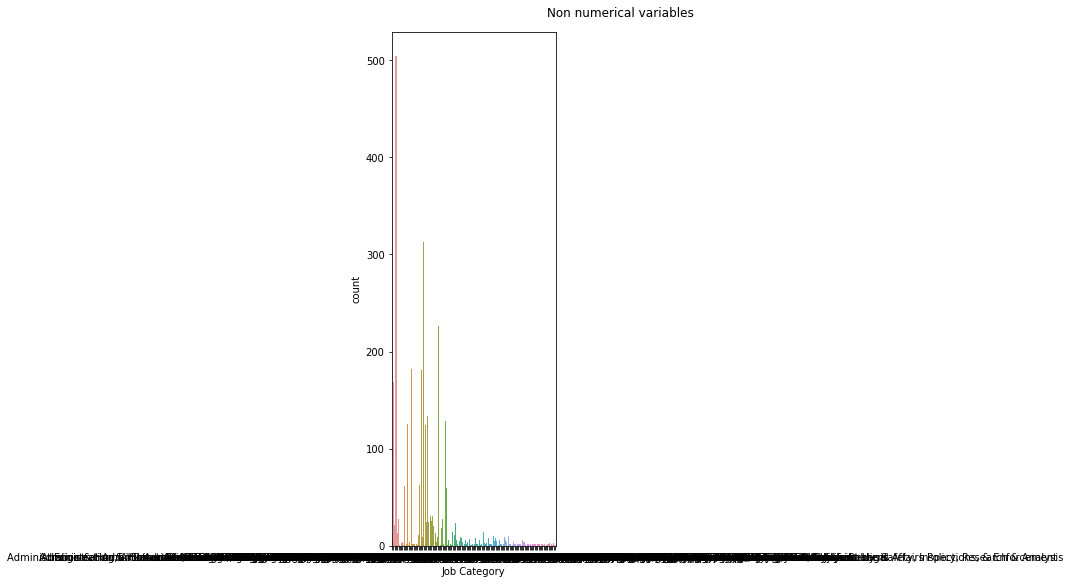

In [67]:
for colname in categorical_columns:
    df_to_plot = pandas_df[colname]

    fig, axs = plt.subplots(constrained_layout=True)
    fig.set_size_inches(12, 8)
    fig.suptitle('Categorical variables')

    sns.countplot(
            data=pandas_df,
            x='Job Category'
        )
plt.show()

In [18]:
# in each category, what is top 10 and bottom 10 categories, that's the average ,

In [65]:
df.groupBy("Job Category").count().sort("count",ascending=False).take(10)

[Row(Job Category='Engineering, Architecture, & Planning', count=504),
 Row(Job Category='Technology, Data & Innovation', count=313),
 Row(Job Category='Legal Affairs', count=226),
 Row(Job Category='Public Safety, Inspections, & Enforcement', count=182),
 Row(Job Category='Building Operations & Maintenance', count=181),
 Row(Job Category='Finance, Accounting, & Procurement', count=169),
 Row(Job Category='Administration & Human Resources', count=134),
 Row(Job Category='Constituent Services & Community Programs', count=129),
 Row(Job Category='Health', count=125),
 Row(Job Category='Policy, Research & Analysis', count=124)]

# Plot continuous variables

unprocessed continuous values 
no null in salary column
add columns salary_floor_hourly and salary_ceiling_hourly
assumption: 8 working hours per day, 22 working days per month 
annual salary -> salary / (22*12*8)
daily salary -> salary / (8)

In [11]:
# def salary_converter(frequency: StringType) -> int:
#     annual_working_hours = 2112  # 12*22*8 12 months * 22 days * 8 hours 
#     daily_working_hours = 8 
# #     if frequency == 'Annual':
# #         return annual_working_hours
# #     elif frequency == 'Daily':
# #         return daily_working_hours
# #     else:
# #         return 1 
#     return 1 

# didn't use udf because it's expensive 

## Salary

In [48]:
normalized_df = df.\
withColumn("hourly_salary_floor",
           expr("""`Salary Range From`/(case when `Salary Frequency` = 'Annual' then 2112 
                           when `Salary Frequency` = 'Daily' then 8 
                           else 1 end)""")).\
withColumn("hourly_salary_ceil",
           expr("""`Salary Range To`/(case when `Salary Frequency` = 'Annual' then 2112 
                           when `Salary Frequency` = 'Daily' then 8 
                           else 1 end)"""))



#### Density plots on all salary - scaled to hourly rate

In [11]:
salary_plot_df = normalized_df.\
select('Job Category','hourly_salary_floor', 'hourly_salary_ceil').toPandas()
# filter(col('Job Category')=='Technology, Data & Innovation').toPandas()

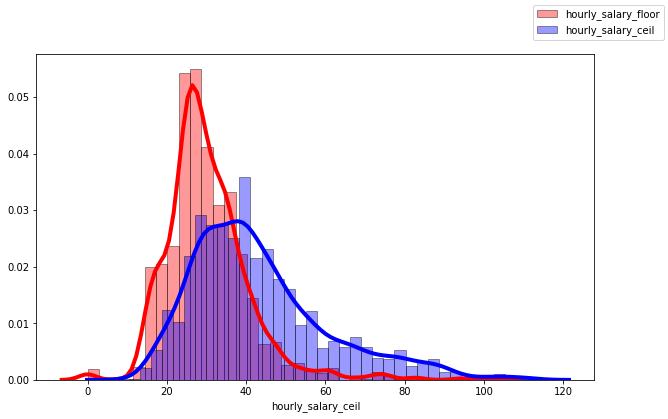

In [15]:
fig = plt.figure(figsize=(10,6))
sns.distplot(salary_plot_df['hourly_salary_floor'], 
             hist=True, 
             kde=True, 
             bins=int(180/5), color = 'red', 
             label='hourly_salary_floor',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

sns.distplot(salary_plot_df['hourly_salary_ceil'],
             hist=True,
             kde=True,
             bins=int(180/5), color = 'blue',
             label='hourly_salary_ceil',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
fig.legend()
plt.show()

#### Density Plot by Job Categories 

Text(0, 0.5, 'Density')

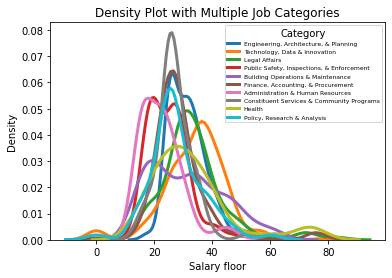

In [26]:
categories = ['Engineering, Architecture, & Planning',
              'Technology, Data & Innovation',
              'Legal Affairs',
              'Public Safety, Inspections, & Enforcement',
              'Building Operations & Maintenance',
              'Finance, Accounting, & Procurement',
              'Administration & Human Resources',
              'Constituent Services & Community Programs',
              'Health',
              'Policy, Research & Analysis']

# Iterate through the five airlines
for category in categories:
    # Subset to the airline
    subset = salary_plot_df[salary_plot_df['Job Category'] == category]
    
    # Draw the density plot
    sns.distplot(subset['hourly_salary_floor'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = category)
    
# Plot formatting
plt.legend(prop={'size': 6}, title = 'Category')
plt.title('Density Plot with Multiple Job Categories')
plt.xlabel('Salary floor')
plt.ylabel('Density')

#### Boxplot by single job category

In [16]:
# subset = salary_plot_df[salary_plot_df['Job Category'] == category]

# 2. Preprocessing and Feature Engineering (functions)

### 2.1 Handle Missing Values

In [8]:
# From conclusion before, apply a heuristic, missing more than half: drop 

In [18]:
normalized_df = normalized_df.drop('Additional information','Hours/Shift','Work Location 1','Recruitment Contact','Post Until')
normalized_df.printSchema()

root
 |-- Job ID: integer (nullable = true)
 |-- Agency: string (nullable = true)
 |-- Posting Type: string (nullable = true)
 |-- # Of Positions: integer (nullable = true)
 |-- Business Title: string (nullable = true)
 |-- Civil Service Title: string (nullable = true)
 |-- Title Code No: string (nullable = true)
 |-- Level: string (nullable = true)
 |-- Job Category: string (nullable = true)
 |-- Full-Time/Part-Time indicator: string (nullable = true)
 |-- Salary Range From: double (nullable = true)
 |-- Salary Range To: double (nullable = true)
 |-- Salary Frequency: string (nullable = true)
 |-- Work Location: string (nullable = true)
 |-- Division/Work Unit: string (nullable = true)
 |-- Job Description: string (nullable = true)
 |-- Minimum Qual Requirements: string (nullable = true)
 |-- Preferred Skills: string (nullable = true)
 |-- To Apply: string (nullable = true)
 |-- Residency Requirement: string (nullable = true)
 |-- Posting Date: timestamp (nullable = true)
 |-- Posting

#### Columns that can be imputed with missing values:

Job Category: 2 rows -> 'na' 

Full-Time/Part-Time indicator: 'na' 

Minimum Qual Requirements: 'na' 

Preferred Skills:'na' 

To Apply : 'na' 

Residency Requirement: 'na'

Posting Date: 'na'

Posting Updated: 'na'

Process Date : 'na'


In [19]:
normalized_df = normalized_df.na.fill('na')

In [20]:
normalized_pandas_df = normalized_df.toPandas()
normalized_pandas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2946 entries, 0 to 2945
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Job ID                         2946 non-null   int32         
 1   Agency                         2946 non-null   object        
 2   Posting Type                   2946 non-null   object        
 3   # Of Positions                 2946 non-null   int32         
 4   Business Title                 2946 non-null   object        
 5   Civil Service Title            2946 non-null   object        
 6   Title Code No                  2946 non-null   object        
 7   Level                          2946 non-null   object        
 8   Job Category                   2946 non-null   object        
 9   Full-Time/Part-Time indicator  2946 non-null   object        
 10  Salary Range From              2946 non-null   float64       
 11  Salary Range To  

# Drop columns

In [21]:
# Study correlation with salary, drop the column that are weakly correlated with salary 

In [22]:
# Columns that don't possess meaning: Job ID, Title Code No

In [23]:
normalized_df = normalized_df.drop('Salary Range From','Salary Range To')
normalized_pandas_df = normalized_pandas_df.drop(['Salary Range From','Salary Range To'],axis=1)

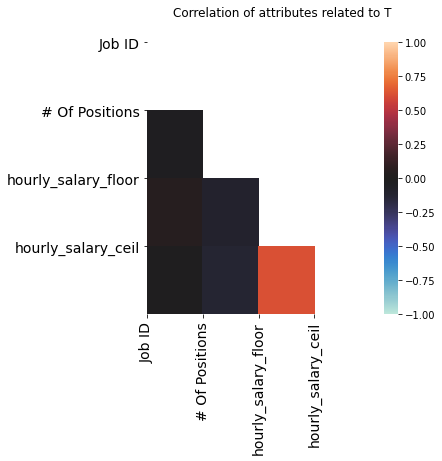

In [32]:
# plotting the correlation in python 
import numpy as np

feature_cols = [i for i in normalized_pandas_df.columns if (normalized_pandas_df[i].dtypes == "float64" or normalized_pandas_df[i].dtypes == "int32")]

df_corr = normalized_pandas_df[feature_cols].corr()
mask = np.triu(np.ones_like(df_corr))

fig, ax = plt.subplots(figsize = (5,5))
fig.suptitle('Correlation of attributes related to T')
sns.heatmap(df_corr,mask=mask,cmap='icefire',fmt='.2f',vmin=-1,vmax=1)

plt.xticks(range(normalized_pandas_df[feature_cols].shape[1]), normalized_pandas_df[feature_cols].columns, fontsize=14, rotation=90)
plt.yticks(range(normalized_pandas_df[feature_cols].shape[1]), normalized_pandas_df[feature_cols].columns, fontsize=14)
plt.show()

In [ ]:
# Use box plot to see the correlation between categorical and continuous variables

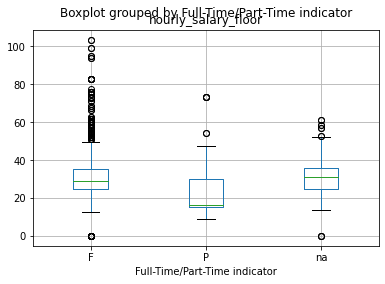

In [29]:
feature_col = 'Full-Time/Part-Time indicator'

normalized_pandas_df.boxplot(column='hourly_salary_floor',by=feature_col,)

In [ ]:
normalized_salary_df = normalized_salary_df.drop('Job ID','Title Code No')

In [37]:
normalized_salary_df.printSchema()

root
 |-- Agency: string (nullable = true)
 |-- Posting Type: string (nullable = true)
 |-- # Of Positions: integer (nullable = true)
 |-- Business Title: string (nullable = true)
 |-- Civil Service Title: string (nullable = true)
 |-- Title Code No: string (nullable = true)
 |-- Level: string (nullable = true)
 |-- Job Category: string (nullable = true)
 |-- Full-Time/Part-Time indicator: string (nullable = true)
 |-- Salary Range From: double (nullable = true)
 |-- Salary Range To: double (nullable = true)
 |-- Salary Frequency: string (nullable = true)
 |-- Work Location: string (nullable = true)
 |-- Division/Work Unit: string (nullable = true)
 |-- Job Description: string (nullable = true)
 |-- Minimum Qual Requirements: string (nullable = true)
 |-- Preferred Skills: string (nullable = true)
 |-- Additional Information: string (nullable = true)
 |-- To Apply: string (nullable = true)
 |-- Hours/Shift: string (nullable = true)
 |-- Work Location 1: string (nullable = true)
 |-- Re

# Apart from visualization, we can analyze feature importance automatically to select features. Will put this section in the end since it would require feature encoding

# Outliers

In [6]:
# handle outliers

In [30]:
normalized_df.select('Job ID', 'Business Title','Job Category').filter(col('hourly_salary_floor')==0).show(5,truncate=False)
print('Having 0 as a salary minimum is weird. At least there should be minimum wage.')

+------+--------------------------------------------------------------------+---------------------------------------------------------------------+
|Job ID|Business Title                                                      |Job Category                                                         |
+------+--------------------------------------------------------------------+---------------------------------------------------------------------+
|399953|Cybersecurity Senior Project Manager                                |Technology, Data & Innovation                                        |
|399953|Cybersecurity Senior Project Manager                                |Technology, Data & Innovation                                        |
|403099|Business/Data Analyst, Bureau of Human Resources and Labor Relations|Administration & Human Resources Health Technology, Data & Innovation|
|403099|Business/Data Analyst, Bureau of Human Resources and Labor Relations|Administration & Human Resources He

In [31]:
normalized_df = normalized_df.filter(col('hourly_salary_floor')!=0)

When it comes to feature enginnering ( beyond the most basics), there are many ways, some are heuristic based, some are machine learning based. Here I applied pretty basic techniques.

For outlier removal, we can remove data beyond IQR * 1.5, we can use IsolationForest from scikit-learn library

# Text processing

#### Extract degree information

In [33]:
text_cleaned_df.select('Job Description','Minimum Qual Requirements').show(1)

+--------------------+-------------------------+
|     Job Description|Minimum Qual Requirements|
+--------------------+-------------------------+
|division of econo...|     1a baccalaureate ...|
+--------------------+-------------------------+
only showing top 1 row



In [34]:
text_cleaned_df.filter(col('Minimum Qual Requirements').contains('high school')).count()


1348

In [35]:
# Dic containing degrees
degrees = {
    'high school':['high school'],
    'bachelor':['baccalaureate','bachelor'],
    'master': ['master'],
    'doctorate':['phd','scd'],
    'legal degree':['state bar']
}

In [36]:
cleaned_df_degree = text_cleaned_df.\
withColumn('degree_required',
           expr("""case when `Minimum Qual Requirements` like '%phd%' or `Minimum Qual Requirements` like '%scd%'
                        then 'doctorate' 
                    when `Minimum Qual Requirements` like '%master%'
                    then 'master'
                    when `Minimum Qual Requirements` like '%baccalaureate%' or  `Minimum Qual Requirements` like '%bachelor%'
                    then 'bachelor'
                    when `Minimum Qual Requirements` like '%high school%'
                    then 'high school'
                    when `Minimum Qual Requirements` like '%state bar%'
                    then 'legal degree'
                    else 'No degree requirement'
                end"""))


In [ ]:
#### Extract skills, create a different dataframe because in this approach, i will explode the column

In [43]:
# skills
# concatenate job description and preferred skills
cleaned_df_skills = cleaned_df_degree.withColumn('skills_raw',col('Preferred Skills'))
cleaned_df_skills_non_null = cleaned_df_skills.na.fill('na')

In [44]:
cleaned_df_skills_non_null.count()

2930

In [45]:
from pyspark.ml.feature import StopWordsRemover, Tokenizer

tokenizer = Tokenizer(inputCol="skills_raw", outputCol="skills_words")
cleaned_df_skills_non_null = tokenizer.transform(cleaned_df_skills_non_null)


In [46]:
remover = StopWordsRemover(inputCol='skills_words', outputCol='filtered_skills')
cleaned_df_skills_non_null = remover.transform(cleaned_df_skills_non_null)

In [47]:
cleaned_df_skills_non_null.select('hourly_salary_floor','hourly_salary_ceil','skills_words').show(10)

+-------------------+------------------+--------------------+
|hourly_salary_floor|hourly_salary_ceil|        skills_words|
+-------------------+------------------+--------------------+
|          20.078125|31.006155303030305|[excellent, inter...|
| 28.759469696969695| 76.71117424242425|                [na]|
|            24.5775|25.842954545454546|[1, , a, high, sc...|
|            24.5775|25.842954545454546|[1, , a, high, sc...|
|               35.0|              35.0|                [na]|
|               35.0|              35.0|                [na]|
| 23.957386363636363| 40.27130681818182|[strong, analytic...|
| 23.969223484848484|35.550662878787875|[in, order, to, a...|
|  42.61363636363637|52.083333333333336|[1, , five, years...|
| 14.527935606060606|23.535511363636363|[experience, with...|
+-------------------+------------------+--------------------+
only showing top 10 rows



In [49]:
cleaned_df_skills_non_null.select('hourly_salary_floor','hourly_salary_ceil',explode('skills_words')).show(50)

+-------------------+------------------+--------------+
|hourly_salary_floor|hourly_salary_ceil|           col|
+-------------------+------------------+--------------+
|          20.078125|31.006155303030305|     excellent|
|          20.078125|31.006155303030305| interpersonal|
|          20.078125|31.006155303030305|           and|
|          20.078125|31.006155303030305|organizational|
|          20.078125|31.006155303030305|        skills|
|          20.078125|31.006155303030305|              |
|          20.078125|31.006155303030305|     excellent|
|          20.078125|31.006155303030305|      analytic|
|          20.078125|31.006155303030305|           and|
|          20.078125|31.006155303030305|   operational|
|          20.078125|31.006155303030305|        skills|
|          20.078125|31.006155303030305|              |
|          20.078125|31.006155303030305|     excellent|
|          20.078125|31.006155303030305|       writing|
|          20.078125|31.006155303030305|        

In [ ]:
non_skill_words = ['experience','knowledge','desirable','skill','skills','plus',
                   'technology','organization','strong']

In [ ]:
# cleaned_df_skills.printSchema()

# Encoding categorical columns

In [50]:
# I use the vanilla encoder available in pyspark

In [51]:
indexer = StringIndexer(inputCol='Agency',outputCol='AgencyIndex').fit(df)
indexed_df = indexer.transform(df)
indexed_df.select('Job ID','Job Category','Salary Range From','AgencyIndex').show(10)
encoder = OneHotEncoder(inputCol='AgencyIndex',outputCol='AgencyVec')
encoded_df = encoder.transform(indexed_df)
encoded_df.select('Job ID','Job Category','Salary Range From','AgencyIndex','AgencyVec').show(10)

+------+--------------------+-----------------+-----------+
|Job ID|        Job Category|Salary Range From|AgencyIndex|
+------+--------------------+-----------------+-----------+
| 87990|                null|          42405.0|       15.0|
| 97899|                null|          60740.0|       15.0|
|132292|Maintenance & Ope...|         51907.68|        1.0|
|132292|Maintenance & Ope...|         51907.68|        1.0|
|133921|Maintenance & Ope...|             35.0|        1.0|
|133921|Maintenance & Ope...|             35.0|        1.0|
|137433|Finance, Accounti...|          50598.0|        2.0|
|138531|Health Public Saf...|          50623.0|        0.0|
|151131|Engineering, Arch...|          90000.0|        1.0|
|152738|Clerical & Admini...|          30683.0|        8.0|
+------+--------------------+-----------------+-----------+
only showing top 10 rows

+------+--------------------+-----------------+-----------+---------------+
|Job ID|        Job Category|Salary Range From|AgencyIndex

# Answering the challenge questions

1. Whats the number of jobs posting per category (Top 10)?
* Assumed that we are looking for unique job posting, instead of summing number of positions in cases where there are multiple positions in 1 job posting

In [4]:
def count_posting_per_category(
    df:DataFrame,
    colname: str = "Job Category") -> DataFrame:
    res_df = df.groupBy(colname).count().sort("count",ascending=False).limit(10)
    return res_df

res = count_posting_per_category(df)
res.show(truncate=False)

+-----------------------------------------+-----+
|Job Category                             |count|
+-----------------------------------------+-----+
|Engineering, Architecture, & Planning    |504  |
|Technology, Data & Innovation            |313  |
|Legal Affairs                            |226  |
|Public Safety, Inspections, & Enforcement|182  |
|Building Operations & Maintenance        |181  |
|Finance, Accounting, & Procurement       |169  |
|Administration & Human Resources         |134  |
|Constituent Services & Community Programs|129  |
|Health                                   |125  |
|Policy, Research & Analysis              |124  |
+-----------------------------------------+-----+



2. Whats the salary distribution per job category?

- Skewed to the right
- Technology has the highest average

In [66]:
plot_df = normalized_df.filter(df['Job Category'] == 'Legal Affairs')
plotdf = plot_df.toPandas()

In [69]:
# plotdf.boxplot(column='hourly_salary_floor',by='Legal Affairs')

In [72]:
def plot_salary_distribution(df:DataFrame,
                             input_category:str,
                             target_colnames:list=['hourly_salary_floor','hourly_salary_ceil'],
                            input_colname:str='Job Category') -> None:
    """
    This function will return 1 plots of distribution of a single category.
    """
    
    # single category box plot
    
    plot_df = df.filter(df[input_colname] == input_category)
    plotdf = plot_df.toPandas()

    for i in target_colnames:
        plotdf.boxplot(column=i, by=input_colname)
    plt.show()

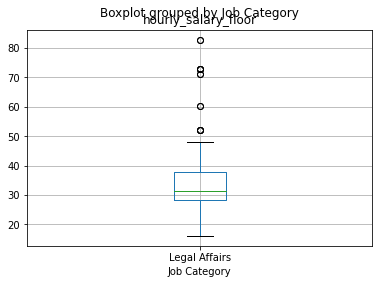

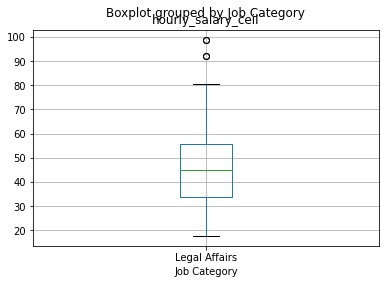

In [71]:
plot_salary_distribution(df = normalized_df,
                            input_category='Legal Affairs',
                            target_colnames=['hourly_salary_floor','hourly_salary_ceil'])

In [75]:
def comparing_distributions(df:DataFrame,
                           categories:list,
                           input_colname:str='Job Category',
                            target_colname: str = 'hourly_salary_floor'
                           ) -> None:
    
    # Iterate through each chosen category
    plot_df = df.toPandas()
    for category in categories:
        # Subset to the category
        subset = plot_df[plot_df[input_colname] == category]

        sns.distplot(subset[target_colname],
                     hist = False,
                     kde = True,
                     kde_kws = {'linewidth': 3},
                     label = category)
    
    # Plot formatting
    plt.legend(prop={'size': 6}, title = 'Category')
    plt.title('Density Plot with Multiple Job Categories')
    plt.xlabel('Salary floor')
    plt.ylabel('Density')

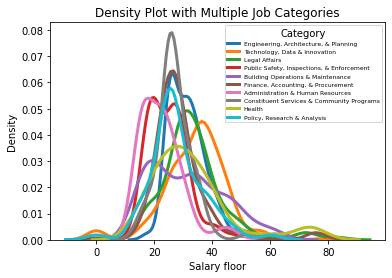

In [76]:
categories = ['Engineering, Architecture, & Planning',
                  'Technology, Data & Innovation',
                  'Legal Affairs',
                  'Public Safety, Inspections, & Enforcement',
                  'Building Operations & Maintenance',
                  'Finance, Accounting, & Procurement',
                  'Administration & Human Resources',
                  'Constituent Services & Community Programs',
                  'Health',
                  'Policy, Research & Analysis']
comparing_distributions(normalized_df, categories)

3. Is there any correlation between the higher degree and the salary?

Yes, below is the plot that shows this correlation.
on average, the higher the degree, the higher the salary.
there are some very noticable outliers, which could be explained by work experience, missing data, level,

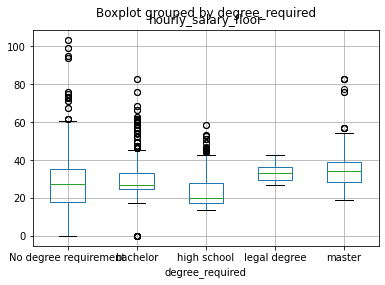

In [87]:
cleaned_df = text_cleaner(normalized_df)

degree_df = extract_degree_info(cleaned_df)

degree_df_plot = degree_df.toPandas()
degree_df_plot.boxplot(column='hourly_salary_floor',by='degree_required',)

3. Whats the job posting having the highest salary per agency?


In [108]:
windowSpec = Window.partitionBy('Agency').orderBy(col('hourly_salary_ceil').desc())


normalized_df \
.withColumn('ranking',dense_rank().over(windowSpec)) \
.select('Agency','Job ID','Posting Type','hourly_salary_ceil','ranking') \
.filter(col('Agency')=='NYC EMPLOYEES RETIREMENT SYS') \
.filter(col('ranking')==1) \
.show(truncate=False)

+----------------------------+------+------------+------------------+-------+
|Agency                      |Job ID|Posting Type|hourly_salary_ceil|ranking|
+----------------------------+------+------------+------------------+-------+
|NYC EMPLOYEES RETIREMENT SYS|413564|Internal    |110.98579545454545|1      |
|NYC EMPLOYEES RETIREMENT SYS|413564|External    |110.98579545454545|1      |
+----------------------------+------+------------+------------------+-------+



4. Whats the job positings average salary per agency for the last 2 years?

The latest data we have in Posting Date is : 2019-12-17 0:00:00

So the timeframe to use is 2017-12-17 - 2019-12-17

In [112]:
filtered_df = normalized_df.filter(col('Posting Date') >= '2017-12-17')


In [115]:
filtered_df.groupBy('Agency').agg(avg('hourly_salary_ceil').alias('average salary')).show(52)

+--------------------+------------------+
|              Agency|    average salary|
+--------------------+------------------+
|LANDMARKS PRESERV...|30.443655303030305|
|     FIRE DEPARTMENT| 44.16099944903581|
|ADMIN FOR CHILDRE...| 41.23856070632797|
|MANHATTAN COMMUNI...|              19.0|
|      TAX COMMISSION|28.589930555555554|
|HRA/DEPT OF SOCIA...|40.515165738025416|
|TAXI & LIMOUSINE ...|34.437856490275884|
|EQUAL EMPLOY PRAC...|31.942945075757578|
|DEPARTMENT OF BUS...| 37.78679296969697|
|DEPT OF DESIGN & ...|54.373146073410155|
|TEACHERS RETIREME...|35.871212121212125|
|FINANCIAL INFO SV...| 52.92115713587488|
|DEPARTMENT OF COR...| 41.94011595365419|
|OFFICE OF EMERGEN...|40.246212121212125|
|HOUSING PRESERVAT...| 40.53387618921776|
|CIVILIAN COMPLAIN...| 35.16653547237076|
|OFFICE OF MANAGEM...|36.696070075757575|
|MAYORS OFFICE OF ...|47.044101731601714|
|DEPT OF CITYWIDE ...|42.171325757575765|
|DEPARTMENT OF CIT...| 37.93087121212121|
|ADMIN TRIALS AND ...|20.615969333

5. What are the highest paid skills in the US market?

# Processing functions

In [4]:
# # test function
# def get_salary_frequency(df):
#     row_list = df.select('Salary Frequency').distinct().collect()
#     return [row['Salary Frequency'] for row in row_list]

In [121]:
def handle_outliers(
    df: DataFrame,
    column: Column,
    lower_bound: FloatType,
    upper_bound: FloatType) -> DataFrame :
    """
    df: spark dataframe
    column: the feature column to transform
    bounds are not inclusive
    
    """
    
    # Validate input column datatype
    if df[[column]].dtypes[0][1] in ['string','timestamp']:
        raise TypeError("Input column must be of numeric values")
    
    # Must have 1 non-null bound
    if lower_bound is None and upper_bound is None:
        raise TypeError("At least one bound must not be null")
    else:
        
        if lower_bound and type(lower_bound) != int:
            raise TypeError("Expected a numerical lower_bound value")
            
        else:
            filtered_df = df.filter(col(column) < lower_bound)

        if upper_bound and type(upper_bound) != int:
            raise TypeError("Expected a numerical upper_bound value")
        else:
            filtered_df = df.filter(col(column) > lower_bound)
    return filtered_df

In [81]:
def text_cleaner(df:DataFrame,
                target_columns:list = ['Job Description', 'Minimum Qual Requirements', 'Preferred Skills'],
                suffix:str = '_cleaned'):
    # remove numerics, punctuations and special characters, and convert everything to lower case
    # Focused on these columns: Job Description, Minimum Qual Requirements, Preferred Skills
    text_cleaned_df = df
    for i in target_columns:
        text_cleaned_df = text_cleaned_df.\
            withColumn(i+suffix,lower(regexp_replace(col(i), "[^a-zA-Z ]", "")))
    return text_cleaned_df

In [85]:
def extract_degree_info(df:DataFrame) -> DataFrame:
    
    # Most common degrees found are below
    #     degrees = {
    #         'high school':['high school'],
    #         'bachelor':['baccalaureate','bachelor'],
    #         'master': ['master'],
    #         'doctorate':['phd','scd'],
    #         'legal degree':['state bar']
    #     }

    df_degree = df.\
    withColumn('degree_required',
               expr("""case when `Minimum Qual Requirements` like '%phd%' or `Minimum Qual Requirements` like '%scd%'
                            then 'doctorate' 
                        when `Minimum Qual Requirements` like '%master%'
                        then 'master'
                        when `Minimum Qual Requirements` like '%baccalaureate%' or  `Minimum Qual Requirements` like '%bachelor%'
                        then 'bachelor'
                        when `Minimum Qual Requirements` like '%high school%'
                        then 'high school'
                        when `Minimum Qual Requirements` like '%state bar%'
                        then 'legal degree'
                        else 'No degree requirement'
                    end"""))
    return df_degree


# Tests

In [131]:
mock_data = [('1001',0),('1002',100),('1003',300)]
def test_handle_outliers(mock_data: list,
                        expected_result: int,
                        schema: list = ['id', 'salary']):
    mock_df = spark.createDataFrame(data=mock_data, schema=schema)
    
    filtereddf = handle_outliers(mock_df,'salary',1,None)
    resdf = filtereddf.select(min('salary'))
    res = resdf.head()[0]

    assert res == expected_result , "expected {}, got {}".format(expected_result, res)

test_handle_outliers(mock_data,100)

In [9]:
mock_data = [('A',10),('B',1),('C',2),('A',1),('B',1),('B',1)]

def test_count_posting_per_category(mock_data: list,
                                    expected_result:str,
                                    schema:list=['category','count']
):
    mock_df = spark.createDataFrame(data=mock_data, schema=schema)
    resdf = count_posting_per_category(mock_df,'category')
    res = resdf.head()[0]
    assert res == expected_result, "expected {}, got {}".format(expected_result, res)
    
test_count_posting_per_category(mock_data, 'B')

In [5]:
# mock_data = [('A', 'Annual'), ('B', 'Daily')]
# expected_result = ['Annual', 'Daily']

In [6]:
# def test_get_salary_frequency(mock_data: list, 
#                               expected_result: list,
#                               schema: list = ['id', 'Salary Frequency']):  
#     mock_df = spark.createDataFrame(data = mock_data, schema = schema)
#     assert get_salary_frequency(mock_df) == expected_result

# CREATE A SUMMARY OF TECHNIQUES AND WORKFLOW